# Neural networks for MNIST handwriting classification

In [2]:
pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.5 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import libraries

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np

### Create the training and validation dataset

In [132]:
#We are going to load the training dataset and convert it to a tensor

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

In [133]:
#Create the validation dataset
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [134]:
#Create the criterion function

criterion = nn.CrossEntropyLoss()

In [135]:
#Create the training-data loader and the validation-data loader objects for both train dataset and validate dataset:

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000, shuffle=False)

In [136]:
# Define a function to display data

def show_data(data_sample):
    plt.imshow(data_sample.numpy().reshape(28, 28), cmap='gray')
    plt.show()

### Explore some of the MNIST data using gzip

In [28]:
import gzip, struct, numpy as np, matplotlib.pyplot as plt
from random import sample
from IPython.display import clear_output

# Read images from compressed file once
with gzip.open('./data/MNIST/raw/train-images-idx3-ubyte.gz', 'rb') as f:
    f.read(16)  # Skip header
    images = np.frombuffer(f.read(), dtype=np.uint8).reshape(-1, 28, 28)

first_run = True
while True:
    if not first_run:
        clear_output()
    first_run = False
    
    # Get user input
    n = int(input("How many preview images would you like to display? You can enter up to 20: "))
    n = min(n, 20)  # Cap at 20
    
    # Display random samples
    indices = sample(range(len(images)), n)
    fig, axes = plt.subplots(int(np.ceil(n/5)), 5, figsize=(10, 2*int(np.ceil(n/5))))
    if n == 1: axes = [axes]
    else: axes = axes.flatten() if n > 5 else axes
    for i, idx in enumerate(indices):
        axes[i].imshow(images[idx], cmap='gray')
        axes[i].axis('off')
    for i in range(n, len(axes)): axes[i].axis('off')  # Hide unused subplots
    plt.tight_layout()
    plt.show()
    
    choice = input("Would you like to go again? (Y/N): ")
    
    if choice.upper() != 'Y': 
        clear_output()
        break

### Explore the MNIST training ground truth dataset

In [162]:
# Read test images and labels once
with gzip.open('./data/MNIST/raw/t10k-images-idx3-ubyte.gz', 'rb') as f:
    f.read(16); images = np.frombuffer(f.read(), dtype=np.uint8).reshape(-1, 28, 28)
with gzip.open('./data/MNIST/raw/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    f.read(8); labels = np.frombuffer(f.read(), dtype=np.uint8)

while True:
    digit = int(input("Enter a digit (0-9): "))
    indices = sample(np.where(labels == digit)[0].tolist(), 10)
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, idx in enumerate(indices):
        axes[i//5, i%5].imshow(images[idx], cmap='gray'); axes[i//5, i%5].axis('off')
    plt.suptitle(f'10 test samples of digit "{digit}"'); plt.show()
    
    choice = input("Try again? (Y/N): ")
    
    if choice.upper() != 'Y': 
        clear_output()
        break
    else:
        clear_output()

### Neural Network Module and Training Function

In [149]:
#Define the neural network module or class class:

class Net(nn.Module):
    
    # Constructor
    def __init__(self, D_in, H1, H2, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
        self.dropout = nn.Dropout(0.3)
    
    # Prediction    
    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = self.dropout(x)
        x = torch.relu(self.linear2(x))
        x = self.dropout(x)
        x = self.linear3(x)
        return x

In [150]:
def train(model, criterion, train_loader, validation_loader, optimizer, epochs=100):
    training_results = {'training_loss': [], 'validation_accuracy': []}
    
    for epoch in tqdm(range(epochs), desc="Training"):
        # Training phase
        model.train()  # Set to training mode
        epoch_loss = 0
        batch_count = 0
        
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x.view(-1, 28 * 28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            batch_count += 1
        
        # Store average loss for the epoch
        avg_loss = epoch_loss / batch_count
        training_results['training_loss'].append(avg_loss)
        
        # Validation phase
        model.eval()  # Set to evaluation mode
        correct = 0
        
        with torch.no_grad():
            for x, y in validation_loader:
                z = model(x.view(-1, 28 * 28))
                _, predicted = torch.max(z, 1)
                correct += (predicted == y).sum().item()
        
        accuracy = 100 * (correct / len(validation_loader.dataset))
        training_results['validation_accuracy'].append(accuracy)
    
    return training_results

### Set up accuracy and loss plots

In [160]:
# Define a function to plot accuracy and loss

def plot_accuracy_loss(training_results):  #Define helper function for plotting the loss
    plt.subplot(2, 1, 1)
    plt.plot(training_results['training_loss'], 'r')
    plt.ylabel('loss')
    plt.title('training loss iterations')
    plt.subplot(2, 1, 2)
    plt.plot(training_results['validation_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epochs')   
    plt.show()

#Define a function for printing the model parameters
def print_model_parameters(model):
    count = 0
    for ele in model.state_dict():
        count += 1
        if count % 2 != 0:
            print ("The following are the parameters for the layer ", count // 2 + 1)
        if ele.find("bias") != -1:
            print("The size of bias: ", model.state_dict()[ele].size())
        else:
            print("The size of weights: ", model.state_dict()[ele].size())


### Define the Neural Network, Optimizer, and Train the Model

In [152]:
#Create the model 

input_dim = 28 * 28
hidden_dim1 = 256
hidden_dim2 = 128
output_dim = 10
model = Net(input_dim, hidden_dim1, hidden_dim2, output_dim)

In [142]:
# Print the parameters for model

print_model_parameters(model)

The following are the parameters for the layer  1
The size of weights:  torch.Size([100, 784])
The size of bias:  torch.Size([100])
The following are the parameters for the layer  2
The size of weights:  torch.Size([10, 100])
The size of bias:  torch.Size([10])


In [153]:
# Set the learning rate and the optimizer

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

### Train the model by using 100 epochs 
* Warning: this process is time-intensive

In [154]:
training_results = train(model, criterion, train_loader, validation_loader, optimizer, epochs=60)

Training: 100%|█████████████████████████████████████████████████████████████| 60/60 [01:41<00:00,  1.69s/it]


# Explore the trained model and evals

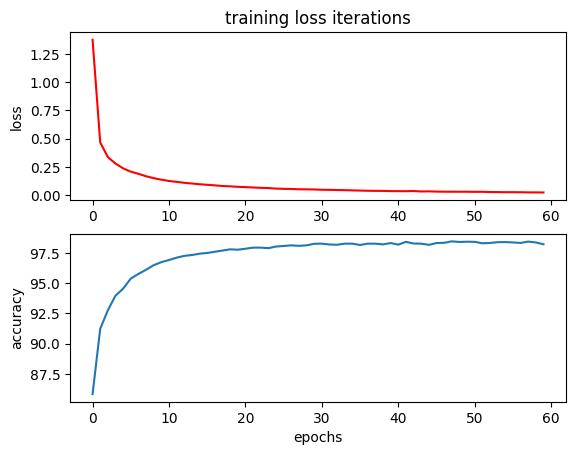

In [155]:
# Show a plot of the accuracy & loss or cost for every epoch
plot_accuracy_loss(training_results)

In [164]:
# Calculate final validation statistics
model.eval()
correct = 0
total = len(validation_dataset)

with torch.no_grad():
    for x, y in validation_loader:
        z = model(x.view(-1, 28 * 28))
        _, predicted = torch.max(z, 1)
        correct += (predicted == y).sum().item()

incorrect = total - correct
print(f"\nFinal Validation Results:")
print(f"Total validation samples: {total}")
print(f"Correct predictions: {correct}")
print(f"Incorrect predictions: {incorrect}")
print(f"Final accuracy: {100 * correct / total:.2f}%")


Final Validation Results:
Total validation samples: 10000
Correct predictions: 9822
Incorrect predictions: 178
Final accuracy: 98.22%


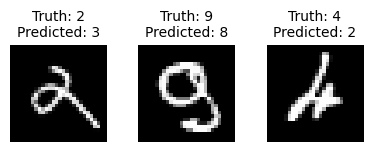

In [157]:
# Plot the first 3 misclassified samples
count = 0
misclassified_data = []

# Collect misclassified samples
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    _, yhat = torch.max(z, 1)
    if yhat != y:
        misclassified_data.append((x, y, yhat.item()))
        count += 1
    if count >= 3:
        break

# Plot all 3 samples in one figure
fig, axes = plt.subplots(1, 3, figsize=(4, 1.5))
for i, (image, true_label, predicted_label) in enumerate(misclassified_data):
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].set_title(f'Truth: {true_label}\nPredicted: {predicted_label}', fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Accuracy on 100 random validation samples: 98.00%


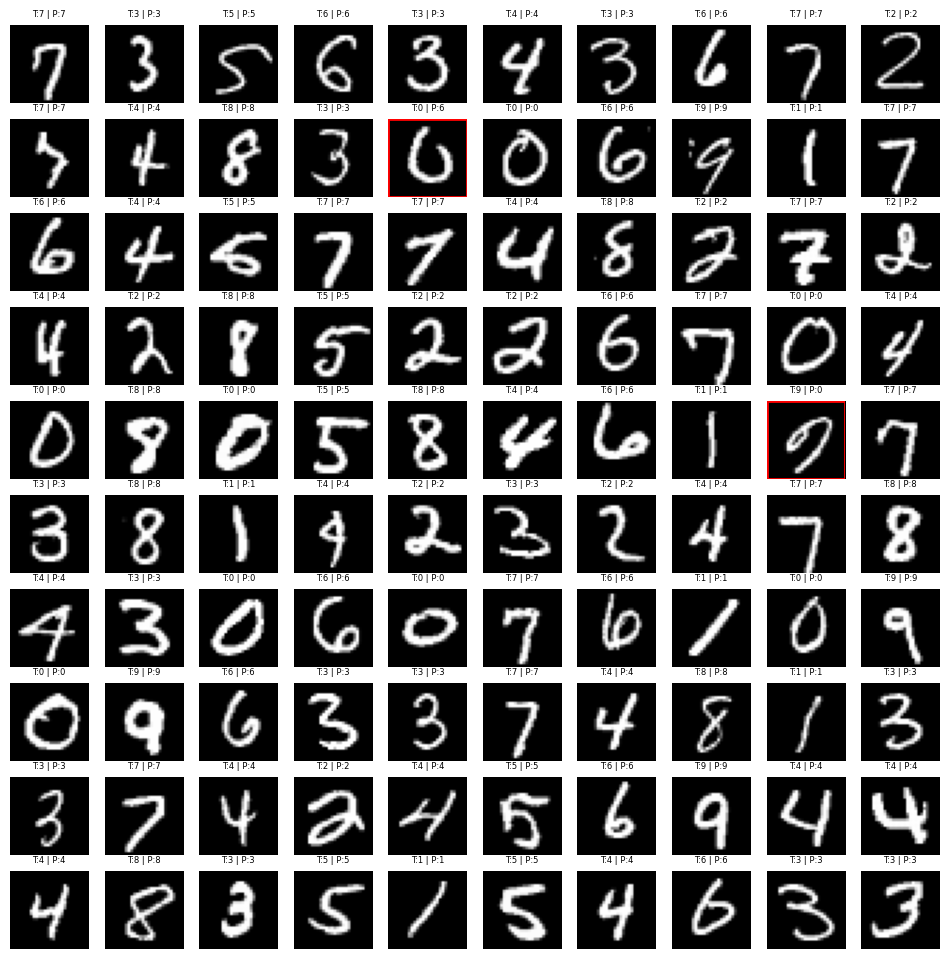

In [183]:
import random
# Function to visualize 100 random predictions from validation set
def visualize_random_predictions(model, validation_loader, n_samples=100):
    model.eval()
    images = []
    labels = []
    preds = []

    # Collect all validation data into memory (fine for MNIST/FashionMNIST-sized sets)
    all_images, all_labels = [], []
    for x, y in validation_loader:
        all_images.append(x)
        all_labels.append(y)
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Randomly pick n_samples indices
    indices = random.sample(range(len(all_labels)), n_samples)
    sample_images = all_images[indices]
    sample_labels = all_labels[indices]

    # Make predictions
    with torch.no_grad():
        outputs = model(sample_images.view(-1, 28*28))
        _, predicted = torch.max(outputs, 1)

    # Accuracy on these samples
    correct = (predicted == sample_labels).sum().item()
    acc = 100 * correct / n_samples
    print(f"Accuracy on {n_samples} random validation samples: {acc:.2f}%")

    # Plotting
    fig, axes = plt.subplots(10, 10, figsize=(12, 12))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        img = sample_images[i].squeeze().numpy()
        ax.imshow(img, cmap="gray")
        true_label = sample_labels[i].item()
        pred_label = predicted[i].item()
        ax.set_title(f"T:{true_label} | P:{pred_label}", fontsize=6)
        ax.axis("off")
    
        # ✅ move inside the loop
        if pred_label != true_label:
            rect = patches.Rectangle(
                (-0.5, -0.5), 28, 28, linewidth=2.0, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)

# Call the function
visualize_random_predictions(model, validation_loader, n_samples=100)